# Tracking keypoints between frames using the Lucas-Kanade algorithm

In this recipe, you will learn how to track keypoints between frames in videos using the sparse Lucas-Kanade optical flow algorithm. This functionality is useful in many computer vision applications, such as object tracking and video stabilization.

In this recipe, we open a video, detect the initial keypoints using the `cv2.goodFeaturesToTrack` function that we used earlier, and start tracking points using the sparse Lucas-Kanade optical flow algorithm, which has been implemented in OpenCV with the `cv2.calcOpticalFlowPyrLK` function. OpenCV implements a pyramidal version of the algorithm, meaning that the optical flow is first calculated in an image of a smaller size, and then refined in a bigger image. The pyramid size is controlled with the `maxLevel` parameter. The function also takes parameters of the Lucas-Kanade algorithm, such as window size (`winSize`) and termination criteria. The other parameters are previous and current frames, and keypoints from the previous frame. The functions return tracked points in the current frame, an array of success flags, and tracking errors.

In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S08\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s08\env

d:\html_doc\program\opencv\packt\s08\env\lib\site-packages
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\pip-20.1b1-py3.8.egg
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S08\env


In [2]:
path="../data/traffic.mp4"
video = cv2.VideoCapture(path)
print('Created capture:', path)
print('Frame count:', int(video.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Frame width:', int(video.get(cv2.CAP_PROP_FRAME_WIDTH)))
print('Frame height:', int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print('Frame rate:',video.get(cv2.CAP_PROP_FPS))


image_frames =[]
c = 0

prev_pts = None
prev_gray_frame = None
tracks = None

while True:
    retval, frame = video.read()
    if not retval: 
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Track the keypoints from a previous frame using the sparse Lucas-Kanade optical flow algorithm or, 
    # if you've just started or pressed C, detect the keypoints so that we have 
    # something to track in the next frame:
    if prev_pts is not None:
        pts, status, errors = cv2.calcOpticalFlowPyrLK(prev_gray_frame,gray_frame,prev_pts,None, 
                                winSize=(15,15),maxLevel=5,
                                criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03))
        good_pts = pts[status == 1]
        if tracks is None: tracks = good_pts
        else: tracks = np.vstack((tracks, good_pts))
        for p in tracks:
            cv2.circle(frame, (p[0], p[1]), 3, (0, 255, 0), -1)
    else:
        pts = cv2.goodFeaturesToTrack(gray_frame, 500, 0.05, 10)
        pts = pts.reshape(-1, 1, 2)
    
    #Remember the current points and current frame. 
    prev_pts = pts
    prev_gray_frame = gray_frame
    
    #Now visualize the results and handle the keyboard input:
    cv2.imshow('frame', frame)
    
    c += 1
    if c % 150 == 0 or c ==1:
        image_frames.append(["frame:{0}".format(c),draw_grid(np.copy(frame))[:,:,[2,1,0]]])
        
    key = cv2.waitKey(1) #& 0xff
    if key == 27: 
        break
    if c % 50 == 0 or key == ord('c'): 
        tracks = None
        prev_pts = None


cv2.destroyAllWindows()

Created capture: ../data/traffic.mp4
Frame count: 1501
Frame width: 1920
Frame height: 1080
Frame rate: 25.0


<ipython-input-2-0b2c85711490>:34: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(frame, (p[0], p[1]), 3, (0, 255, 0), -1)


len(calcOpticalFlowPyrLK) == 11
0 1


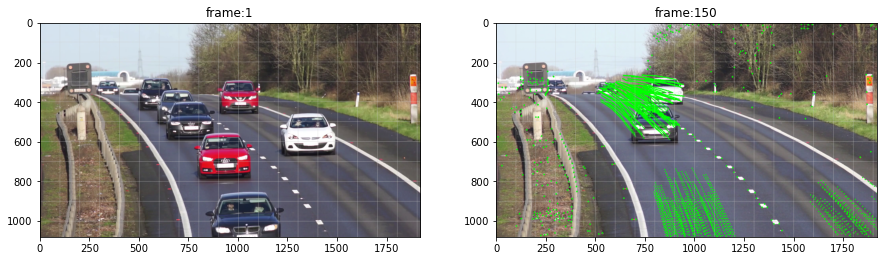

2 3


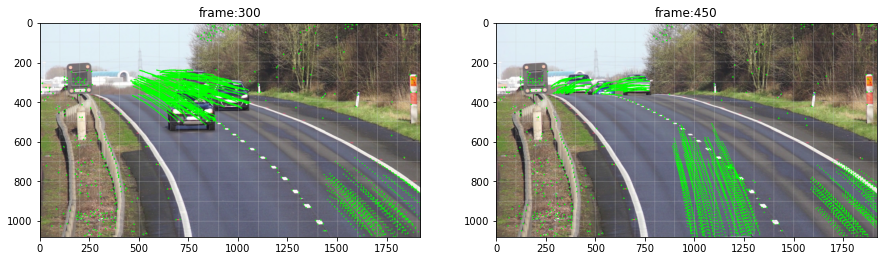

4 5


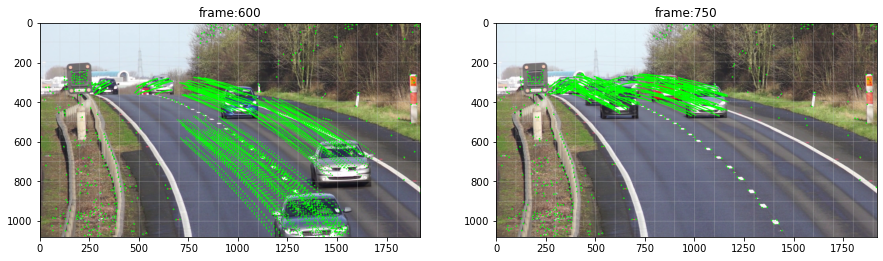

6 7


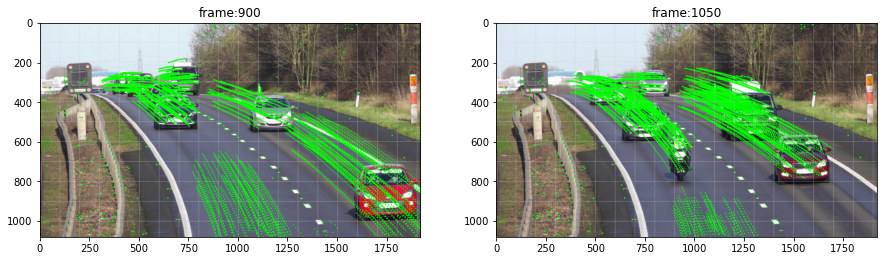

8 9


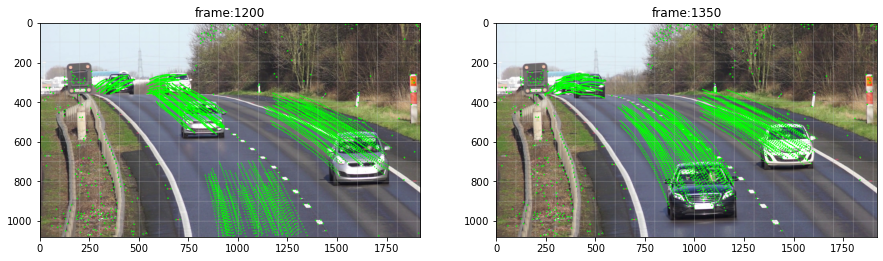

10 11


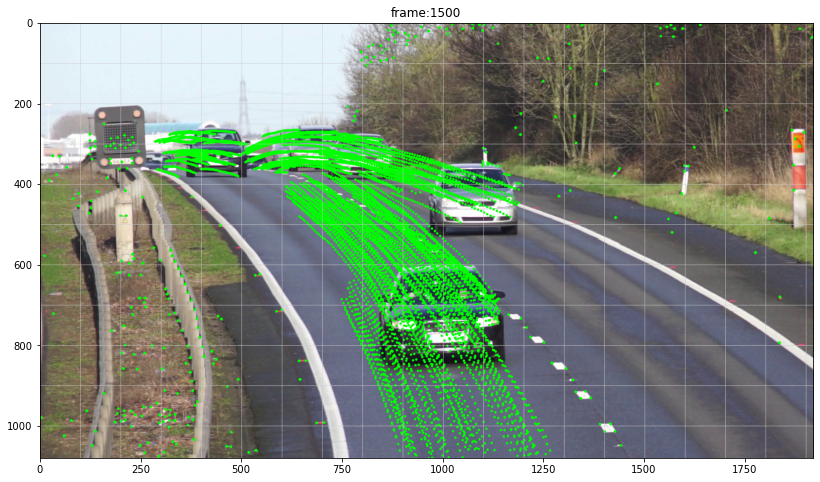

In [3]:
print("len(calcOpticalFlowPyrLK) ==", len(image_frames))
k = 2
for i in range(0,len(image_frames),k):
    print(i,i+k-1)
    plt_view_image(plt,image_frames[i:i+k], figsize=(15,8), axis='on', cmap='gray')